# Topic Modeling wiht Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a method for reducing the dimnesionality of documents treated as a bag of words. It is used for document classification, clustering and retrieval. For example, LSA can be used to search for prior art given a new patent application. In this homework, we will implement a small library for simple latent semantic analysis as a practical example of the application of SVD. The ideas are very similar to PCA.

We will implement a toy example of LSA to get familiar with the ideas. If you want to use LSA or similar methods for statiscal language analyis, the most efficient Python library is probably [gensim](https://radimrehurek.com/gensim/) - this also provides an online algorithm - i.e. the training information can be continuously updated. Other useful functions for processing natural language can be found in the [Natural Lnaguage Toolkit](http://www.nltk.org/).

**Note**: The SVD from scipy.linalg performs a full decomposition, which is inefficient since we only need to decompose until we get the first k singluar values. If the SVD from `scipy.linalg` is too slow, please use the `sparsesvd` function from the [sparsesvd](https://pypi.python.org/pypi/sparsesvd/) package to perform SVD instead.  You can install in the usual way with 
```
!pip install sparsesvd
```

Then import the following
```python
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix 
```

and use as follows
```python
sparsesvd(csc_matrix(M), k=10)
```

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as la
import scipy.stats as st

**Exercise 1 (10 points)**.  Calculating pairwise distance matrices.

Suppose we want to construct a distance matrix between the rows of a matrix. For example, given the matrix 

```python
M = np.array([[1,2,3],[4,5,6]])
```

the distance matrix using Euclidean distance as the measure would be
```python
[[ 0.000  1.414  2.828]
 [ 1.414  0.000  1.414]
 [ 2.828  1.414  0.000]] 
```
if $M$ was a collection of column vectors.

Write a function to calculate the pairwise-distance matrix given the matrix $M$ and some arbitrary distance function. Your functions should have the following signature:
```
def func_name(M, distance_func):
    pass
```

0. Write a distance function for the Euclidean, squared Euclidean and cosine measures.
1. Write the function using looping for M as a collection of row vectors.
2. Write the function using looping for M as a collection of column vectors.
3. Wrtie the function using broadcasting for M as a colleciton of row vectors.
4. Write the function using broadcasting for M as a colleciton of column vectors. 

For 3 and 4, try to avoid using transposition (but if you get stuck, there will be no penalty for using transpoition). Check that all four functions give the same result when applied to the given matrix $M$.

In [2]:
# Questions 1.1 to 1.5

def squared_euclidean_norm(u, axis=-1):
    return (u**2).sum(axis)

def euclidean_norm(u, axis=-1):
    return np.sqrt(squared_euclidean_norm(u, axis))

def squared_euclidean_dist(u, v, axis=-1):
    """Returns squared Euclidean distance between two vectors."""
    return squared_euclidean_norm(u-v, axis)

def euclidean_dist(u, v, axis=-1):
    """Return Euclidean distacne between two vectors."""
    return np.sqrt(squared_euclidean_dist(u, v, axis))
    
def cosine_dist(u, v, axis=-1):
    """Returns cosine of angle betwwen two vectors."""
    # return 1 - np.dot(u, v)/(la.norm(u)*la.norm(v))
    return 1 - (u * v).sum(axis)/(euclidean_norm(u, axis) * euclidean_norm(v, axis))

def loop_row_pdist(M, f):
    """REturns pairwise-distance matrix assuming M consists of row vectors.."""
    nrows, ncols = M.shape
    return np.array([[f(M[u,:], M[v,:]) for u in range(nrows)] 
                                        for v in range(nrows)])

def loop_col_pdist(M, f):
    """REturns pairwise-distance matrix assuming M consists of column vectors.."""
    nrows, ncols = M.shape
    return np.array([[f(M[:,u], M[:,v]) for u in range(ncols)] 
                                        for v in range(ncols)])

def broadcast_row_pdist(M, f):
    """REturns pairwise-distance matrix assuming M consists of row vectors.."""
    return f(M[None,:,:], M[:,None,:])

def broadcast_col_pdist(M, f):
    """REturns pairwise-distance matrix assuming M consists of column vectors.."""
    return f(M[:,None,:], M[:,:,None], axis=0)

In [3]:
# Q1 checking reuslts

M = np.array([[1,2,3],[4,5,6]])

# dist = euclidean_dist
for dist in (cosine_dist, euclidean_dist, squared_euclidean_dist):
    print(loop_row_pdist(M, dist), '\n')
    print(broadcast_row_pdist(M, dist), '\n')
    print(loop_col_pdist(M, dist), '\n')
    print(broadcast_col_pdist(M, dist))

[[0.00000000e+00 2.53681538e-02]
 [2.53681538e-02 2.22044605e-16]] 

[[0.00000000e+00 2.53681538e-02]
 [2.53681538e-02 2.22044605e-16]] 

[[ 0.00000000e+00  9.16983196e-03  2.38129398e-02]
 [ 9.16983196e-03 -2.22044605e-16  3.45424176e-03]
 [ 2.38129398e-02  3.45424176e-03  1.11022302e-16]] 

[[ 0.00000000e+00  9.16983196e-03  2.38129398e-02]
 [ 9.16983196e-03 -2.22044605e-16  3.45424176e-03]
 [ 2.38129398e-02  3.45424176e-03  1.11022302e-16]]
[[0.         5.19615242]
 [5.19615242 0.        ]] 

[[0.         5.19615242]
 [5.19615242 0.        ]] 

[[0.         1.41421356 2.82842712]
 [1.41421356 0.         1.41421356]
 [2.82842712 1.41421356 0.        ]] 

[[0.         1.41421356 2.82842712]
 [1.41421356 0.         1.41421356]
 [2.82842712 1.41421356 0.        ]]
[[ 0 27]
 [27  0]] 

[[ 0 27]
 [27  0]] 

[[0 2 8]
 [2 0 2]
 [8 2 0]] 

[[0 2 8]
 [2 0 2]
 [8 2 0]]


**Exercise 2 (20 points)**. Write 3 functions to calculate the term frequency (tf), the inverse document frequency (idf) and the product (tf-idf). Each function should take a single argument `docs`, which is a dictionary of (key=identifier, value=dcoument text) pairs, and return an appropriately sized array. Convert '-' to ' ' (space), remove punctuation, convert text to lowercase and split on whitespace to generate a collection of terms from the dcoument text.

- tf = the number of occurrences of term $i$ in document $j$
- idf = $\log \frac{n}{1 + \text{df}_i}$ where $n$ is the total number of documents and $\text{df}_i$ is the number of documents in which term $i$ occurs.

Print the table of tf-idf values for the following document collection

```
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}
```

In [21]:
# Questino 2.1
def tf(doc):
    """Returns the number of times each term occurs in a dcoument.
    We preprocess the document to strip punctuation and convert to lowercase.
    Terms are found by splitting on whitespace."""
    from collections import Counter
    from string import punctuation

    terms = doc.lower().replace('-', ' ').translate(str.maketrans('','',punctuation)).split()
    return Counter(terms)

def tfs(docs):
    """Create a term freqeuncy dataframe from a dictionary of documents."""
    from operator import add

    df = pd.DataFrame({k: tf(v) for k, v in docs.items()}).fillna(0)
    return df

# Question 2.2
def idf(docs):
    """Find inverse document frequecny series from a dictionry of doucmnets."""
    term_freq = tfs(docs)
    num_docs = len(docs)
    doc_freq = (term_freq > 0).sum(axis=1)
    return np.log(num_docs/(1 + doc_freq))

# Question 2.3
def tf_idf(docs):
    """Return the product of the term-frequency and inverse document freqeucny."""
    return tfs(docs).mul(idf(docs), axis=0)

    # return tfs(docs) * idf(docs)[:, None]

In [5]:
# Question 2.4

s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}

tf_idf(docs)

,s1,s2,s3,s4
the,-0.223144,-0.223144,-0.669431,-1.115718
quick,0.693147,0.000000,0.000000,0.000000
brown,0.287682,0.287682,0.000000,0.000000
fox,0.287682,0.287682,0.000000,0.000000
jumps,0.000000,2.772589,0.000000,0.000000
over,0.000000,0.693147,0.000000,0.000000
lazy,0.000000,0.000000,0.693147,0.000000
dog,0.000000,0.000000,0.287682,0.287682
elephant,0.000000,0.000000,0.287682,0.287682
peacock,0.000000,0.000000,0.000000,0.693147


**Exercise 3 (20 points)**. 

1. Write a function that takes a matrix $M$ and an integer $k$ as arguments, and reconstructs a reduced matrix using only the $k$ largest singular values. Use the `scipy.linagl.svd` function to perform the decomposition. This is the least squares approximation to the matrix $M$ in $k$ dimensions.

2. Apply the function you just wrote to the following term-frequency matrix for a set of $9$ documents using $k=2$ and print the reconstructed matrix $M'$.
```
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])
```

3. Calculate the pairwise correlation matrix for the original matrix M and the reconstructed matrix using $k=2$ singular values (you may use [scipy.stats.spearmanr](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) to do the calculations). Consider the fist 5 sets of documents as one group $G1$ and the last 4 as another group $G2$ (i.e. first 5 and last 4 columns). What is the average within group correlation for $G1$, $G2$ and the average cross-group correlation for G1-G2 using either $M$ or $M'$. (Do not include self-correlation in the within-group calculations.).

In [23]:
def svd_projection(M, k):
    """Returns the matrix M reconstructed using only k singluar values"""
    U, s, V = la.svd(M, full_matrices=False)
    s[k:] = 0
    M_ = U.dot(np.diag(s).dot(V))
    return M_

In [58]:
# Question 3.1

def svd_projection(M, k):
    """Returns the matrix M reconstructed using only k singluar values"""
    U, s, V = la.svd(M, full_matrices=False)
    s[k:] = 0
    M_ = U.dot(np.diag(s).dot(V))
    
    try:
        return pd.DataFrame(M_, index=M.index, columns=M.columns)
    except AttributeError:
        return M_

In [59]:
# Qeustion 3.2

M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 2, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 1]])

Md = svd_projection(M, 2)
Md

array([[ 0.16205797,  0.40049828,  0.37895454,  0.46756626,  0.17595367,
        -0.05265495, -0.11514284, -0.15910198, -0.09183827],
       [ 0.14058529,  0.36980077,  0.32899603,  0.40042722,  0.16497247,
        -0.03281545, -0.07056857, -0.09676827, -0.04298073],
       [ 0.15244948,  0.50500444,  0.35793658,  0.41010678,  0.23623173,
         0.02421652,  0.05978051,  0.0868573 ,  0.12396632],
       [ 0.25804933,  0.84112343,  0.60571995,  0.69735717,  0.39231795,
         0.03311801,  0.08324491,  0.12177239,  0.18737973],
       [ 0.44878975,  1.23436483,  1.0508615 ,  1.26579559,  0.55633139,
        -0.07378998, -0.15469383, -0.20959816, -0.04887954],
       [ 0.15955428,  0.5816819 ,  0.37521897,  0.41689768,  0.27654052,
         0.05590374,  0.1322185 ,  0.18891146,  0.21690761],
       [ 0.15955428,  0.5816819 ,  0.37521897,  0.41689768,  0.27654052,
         0.05590374,  0.1322185 ,  0.18891146,  0.21690761],
       [ 0.21846278,  0.54958058,  0.51096047,  0.62805802,  0

In [54]:
# Question 3.3

# Results for full-rank matrix

G1 = M[:, :5]
G2 = M[:, 5:]
cor_within_group = st.spearmanr(G1).correlation
mean_cor_within_group = np.sum(la.triu(cor_within_group, 1)) /10
cor_within_group2 = st.spearmanr(G2).correlation
mean_cor_within_group2 = np.sum(la.triu(cor_within_group2, 1)) /10
print(mean_cor_within_group)
print(mean_cor_within_group2)

0.010577686629862798
0.26107062889188376


In [55]:
rho, pval = st.spearmanr(M) #9 by 9
rho[5:, :5].mean()

-0.30756218890559084

In [56]:
# Results after LSA
# G1/G1, G2/G2 and G1/G2 average correlation

G1 = Md[:, :5]
G2 = Md[:, 5:]
cor_within_group = st.spearmanr(G1).correlation
mean_cor_within_group = np.sum(la.triu(cor_within_group, 1)) /10
cor_within_group2 = st.spearmanr(G2).correlation
mean_cor_within_group2 = np.sum(la.triu(cor_within_group2, 1)) /10
print(mean_cor_within_group)
print(mean_cor_within_group2)

0.8650795342544025
0.5937062937062938


In [57]:
rho, pval = st.spearmanr(Md)
rho[5:, :5].mean()

-0.6772813081926677

**Exercise 4 (40 points)**. Clustering with LSA

1. Begin by loading a pubmed database of selected article titles using 'pickle'. With the following:
```import pickle
docs = pickle.load(open('pubmed.pic', 'rb'))```

    Create a tf-idf matrix for every term that appears at least once in any of the documents. What is the shape of the tf-idf matrix? 

2. Perform SVD on the tf-idf matrix to obtain $U \Sigma V^T$ (often written as $T \Sigma D^T$ in this context with $T$ representing the terms and $D$ representing the documents). If we set all but the top $k$ singular values to 0, the reconstructed matrix is essentially $U_k \Sigma_k V_k^T$, where $U_k$ is $m \times k$, $\Sigma_k$ is $k \times k$ and $V_k^T$ is $k \times n$. Terms in this reduced space are represented by $U_k \Sigma_k$ and documents by $\Sigma_k V^T_k$. Reconstruct the matrix using the first $k=10$ singular values.

3. Use agglomerative hierachical clustering with complete linkage to plot a dendrogram and comment on the likely number of  document clusters with $k = 100$. Use the dendrogram function from [SciPy ](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

4. Determine how similar each of the original documents is to the new document `mystery.txt`. Since $A = U \Sigma V^T$, we also have $V = A^T U S^{-1}$ using orthogonality and the rule for transposing matrix products. This suggests that in order to map the new document to the same concept space, first find the tf-idf vector $v$ for the new document - this must contain all (and only) the terms present in the existing tf-idx matrix. Then the query vector $q$ is given by $v^T U_k \Sigma_k^{-1}$. Find the 10 documents most similar to the new document and the 10 most dissimilar. 

In [58]:
# Quesiton 4.1

import pickle

docs = pickle.load(open('pubmed.pic', 'rb'))
df = tf_idf(docs)
df.shape

(6488, 178)

In [59]:
# Question 4.2

k = 10
T, s, D = la.svd(df)

print(T.shape, s.shape, D.shape, '\n')

df_10 = T[:,:k].dot(np.diag(s[:k]).dot(D[:k,:]))
assert(df.shape == df_10.shape)
df_10

(6488, 6488) (178,) (178, 178) 



array([[ 6.86673422e+00,  3.65522481e-02, -2.55095575e-02, ...,
         1.58562741e-01,  3.97661045e-02,  4.01704711e-02],
       [ 8.68535607e+00, -5.44703800e-02, -7.41685745e-02, ...,
        -8.35117856e-02, -1.12932222e-03,  3.42304492e-02],
       [-1.11304267e-01, -6.68428904e-02, -5.13236099e-02, ...,
        -6.75714875e-02, -2.37799181e-02, -2.85583685e-02],
       ...,
       [ 1.71152246e-02,  2.36495790e-02,  2.05984131e-02, ...,
         3.87415631e-03,  6.01102856e-03,  1.16392836e-02],
       [ 1.71152246e-02,  2.36495790e-02,  2.05984131e-02, ...,
         3.87415631e-03,  6.01102856e-03,  1.16392836e-02],
       [ 1.71152246e-02,  2.36495790e-02,  2.05984131e-02, ...,
         3.87415631e-03,  6.01102856e-03,  1.16392836e-02]])

In [60]:
# Question 4.2 (alternative solution 1 setting unwanted singluar values to zero)

T, s, D = la.svd(df, full_matrices=False)
print(T.shape, s.shape, D.shape, '\n')

s[10:] = 0
df_10 = T.dot(np.diag(s).dot(D))
assert(df.shape == df_10.shape)
df_10

(6488, 178) (178,) (178, 178) 



array([[ 6.86673422e+00,  3.65522481e-02, -2.55095575e-02, ...,
         1.58562741e-01,  3.97661045e-02,  4.01704711e-02],
       [ 8.68535607e+00, -5.44703800e-02, -7.41685745e-02, ...,
        -8.35117856e-02, -1.12932222e-03,  3.42304492e-02],
       [-1.11304267e-01, -6.68428904e-02, -5.13236099e-02, ...,
        -6.75714875e-02, -2.37799181e-02, -2.85583685e-02],
       ...,
       [ 1.71152246e-02,  2.36495790e-02,  2.05984131e-02, ...,
         3.87415631e-03,  6.01102856e-03,  1.16392836e-02],
       [ 1.71152246e-02,  2.36495790e-02,  2.05984131e-02, ...,
         3.87415631e-03,  6.01102856e-03,  1.16392836e-02],
       [ 1.71152246e-02,  2.36495790e-02,  2.05984131e-02, ...,
         3.87415631e-03,  6.01102856e-03,  1.16392836e-02]])

In [6]:
! pip install sparsesvd

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [62]:
# Question 4.2 (alternative solution 2 using sparsesvd)

from scipy.sparse import csc_matrix 
from sparsesvd import sparsesvd 

k = 10
T, s, D = sparsesvd(csc_matrix(df), k=k)

print(T.shape, s.shape, D.shape, '\n')
df_10 = T.T.dot(np.diag(s).dot(D))
assert(df.shape == df_10.shape)
print(df_10)

(10, 6488) (10,) (10, 178) 

[[ 6.86673422e+00  3.65522483e-02 -2.55095574e-02 ...  1.58562741e-01
   3.97661046e-02  4.01704712e-02]
 [ 8.68535607e+00 -5.44703798e-02 -7.41685743e-02 ... -8.35117852e-02
  -1.12932215e-03  3.42304493e-02]
 [-1.11304267e-01 -6.68428904e-02 -5.13236099e-02 ... -6.75714875e-02
  -2.37799182e-02 -2.85583685e-02]
 ...
 [ 1.71152246e-02  2.36495790e-02  2.05984131e-02 ...  3.87415631e-03
   6.01102856e-03  1.16392836e-02]
 [ 1.71152246e-02  2.36495790e-02  2.05984131e-02 ...  3.87415631e-03
   6.01102856e-03  1.16392836e-02]
 [ 1.71152246e-02  2.36495790e-02  2.05984131e-02 ...  3.87415631e-03
   6.01102856e-03  1.16392836e-02]]


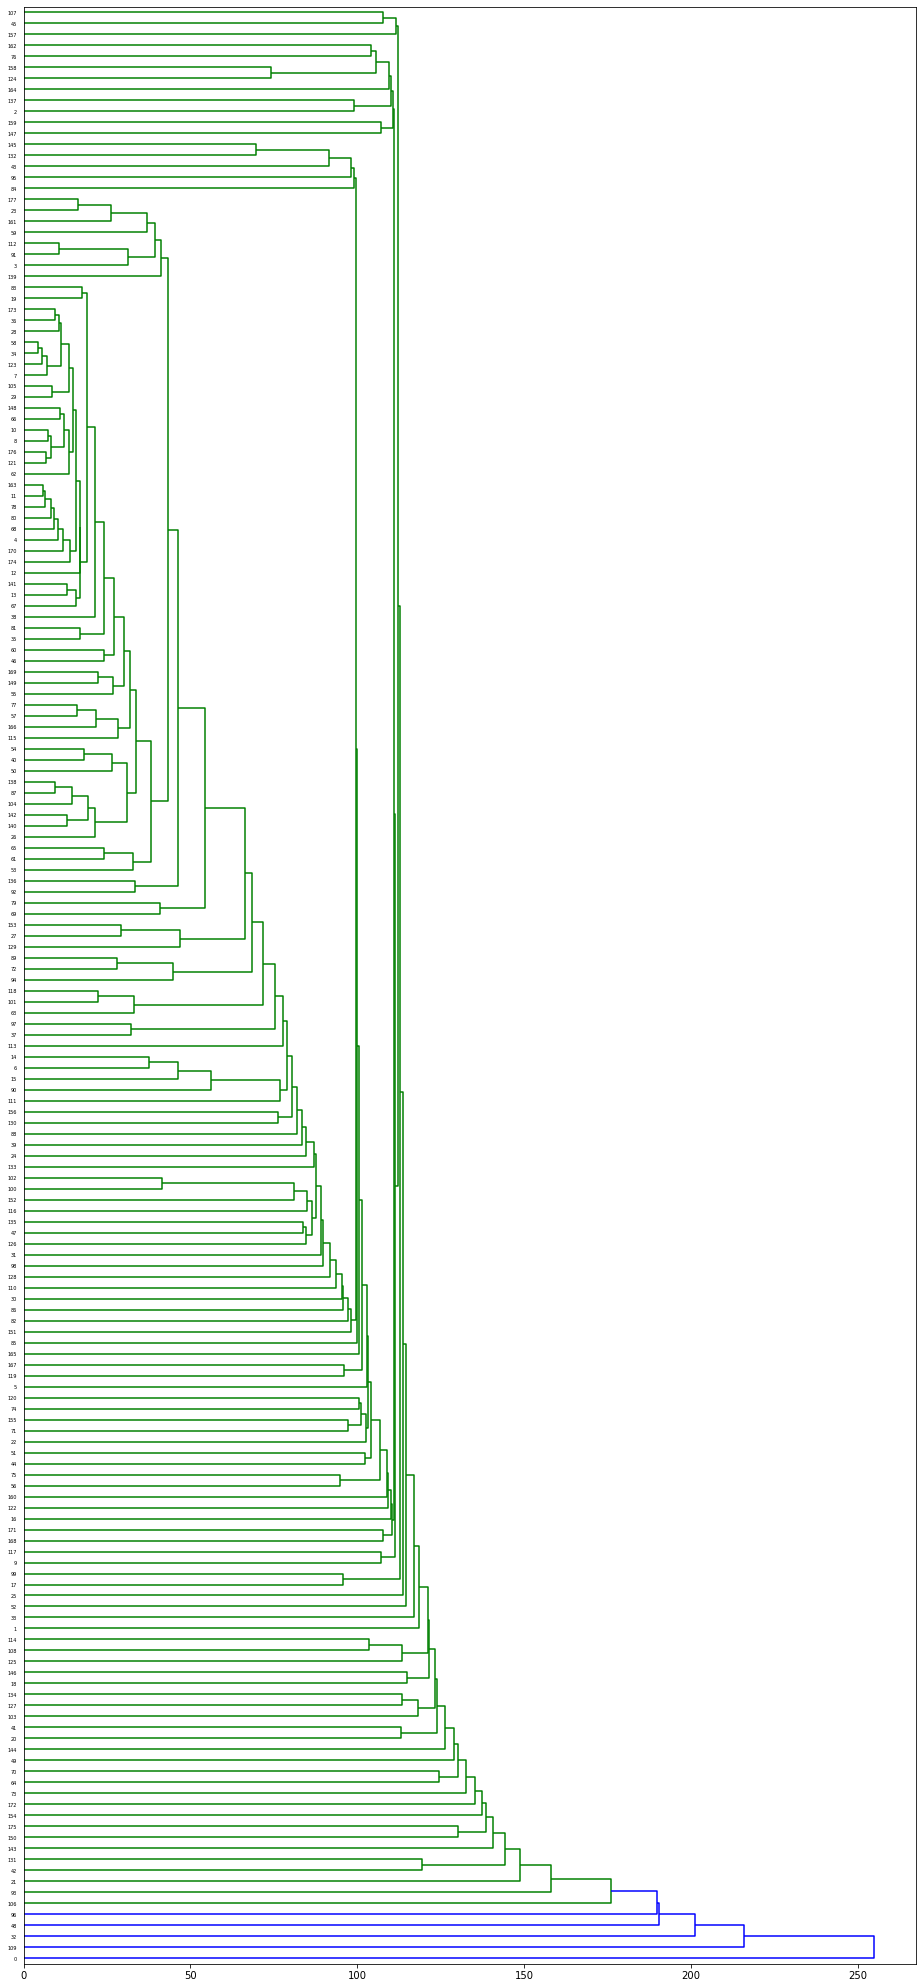

In [63]:
# Question 4.3

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

plt.figure(figsize=(16,36))
T, s, D = sparsesvd(csc_matrix(df), k=100)
x = np.diag(s).dot(D).T
data_dist = pdist(x) # computing the distance
data_link = linkage(data_dist, method = 'complete') # computing the linkage

R = dendrogram(data_link, orientation='right')

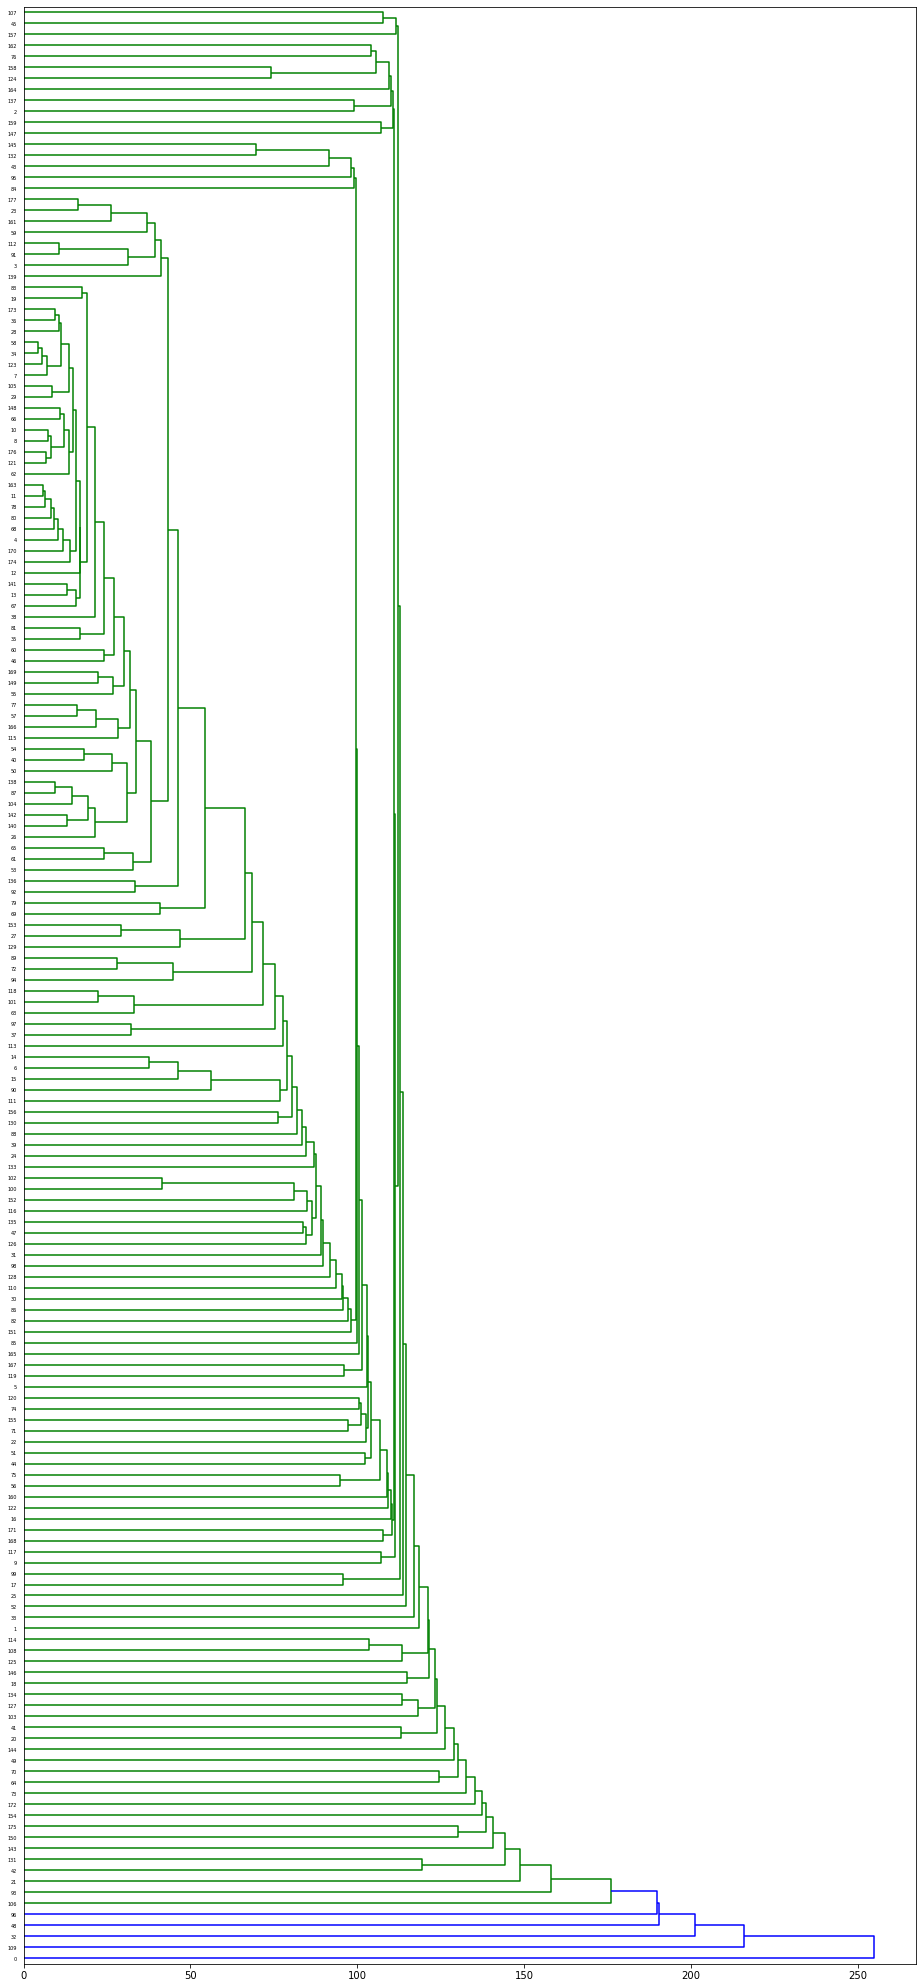

In [65]:
# Question 4.3 alternative

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

plt.figure(figsize=(16,36))
T, s, D = sparsesvd(csc_matrix(df), k=100)
x = np.diag(s).dot(D).T
data_link = linkage(x, method = 'complete') # computing the linkage

R = dendrogram(data_link, orientation='right')

In [78]:
# Quesiton 4.4


T, s, D = sparsesvd(csc_matrix(df), k=100) #k = 10

doc = {'mystery': open('mystery.txt').read()}
terms = tf_idf(doc) ######## or calculate the idf from the original text corpus
query_terms = df.join(terms).fillna(0)['mystery']
q = query_terms.T.dot(T.T.dot(np.diag(1.0/s)))

ranked_docs = df.columns[np.argsort(cosine_dist(q, x))]
print("Query article:", )
print(' '.join(line.strip() for line in doc['mystery'].splitlines()[:2]))
print()
print("Most similar")
print('='*80)
for i, title in enumerate(ranked_docs[:10]):
    print('%03d' % i, title)

print()
print("Most dissimilar")
print('='*80)
for i, title in enumerate(ranked_docs[-10:]):
    print('%03d' % (len(docs) - i), title)

Query article:
﻿Intensive blood-glucose control with sulphonylureas or insulin compared with conventional treatment and risk of complications in patients with type 2 diabetes

Most similar
000 IRGM3 contributes to immunopathology and is required for differentiation of antigen-specific effector CD8+ T cells in experimental cerebral malaria.
001 CD40 Is Required for Protective Immunity against Liver Stage Plasmodium Infection.
002 CD4 T-cell subsets in malaria: TH1/TH2 revisited.
003 Antibodies to the Plasmodium falciparum proteins MSPDBL1 and MSPDBL2 opsonise merozoites, inhibit parasite growth and predict protection from clinical malaria.
004 Crystal Structures of the Carboxyl cGMP Binding Domain of the Plasmodium falciparum cGMP-dependent Protein Kinase Reveal a Novel Capping Triad Crucial for Merozoite Egress.
005 Dopamine Increases CD14+CD16+ Monocyte Migration and Adhesion in the Context of Substance Abuse and HIV Neuropathogenesis.
006 Nerve Growth Factor Potentiates Nicotinic Syn

Notes on the Pubmed articles
----

These were downloaded with the following script.

```python
from Bio import Entrez, Medline
Entrez.email = "YOUR EMAIL HERE"
import pickle

try:
    docs = pickle.load(open('pubmed.pic', 'rb'))
except Exception, e:
    print e

    docs = {}
    for term in ['plasmodium', 'diabetes', 'asthma', 'cytometry']:
        handle = Entrez.esearch(db="pubmed", term=term, retmax=50)
        result = Entrez.read(handle)
        handle.close()
        idlist = result["IdList"]
        handle2 = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
        result2 = Medline.parse(handle2)
        for record in result2:
            title = record.get("TI", None)
            abstract = record.get("AB", None)
            if title is None or abstract is None:
                continue
            docs[title] = '\n'.join([title, abstract])
            print(title)
        handle2.close()
    pickle.dump(docs, open('pubmed.pic', 'wb'))
docs.values()
```